In [26]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import glob

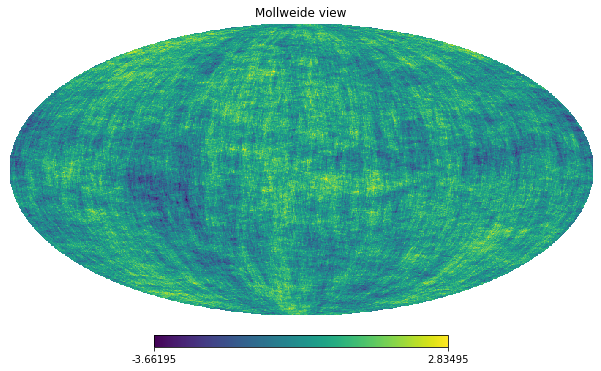

In [27]:
m = hp.read_map('./input_maps/E/E_map_0.fits', field=None, verbose=False, dtype=np.float64)
hp.mollview(m[1])

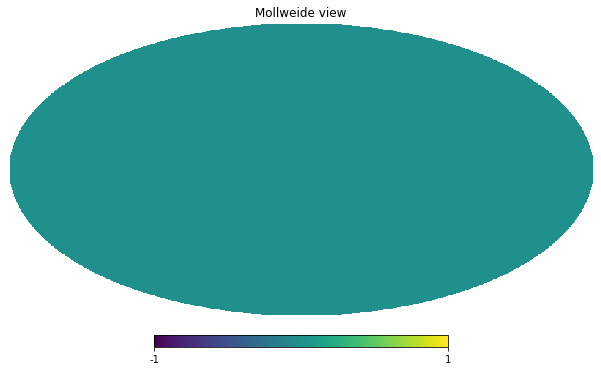

In [36]:
m = hp.read_map('./out_maps/0/E_telescope_all_time_all_binned.fits', field=None, verbose=False, dtype=np.float64)
hp.mollview(m[1])

In [2]:
nreal = 10

E_Q_maps = [hp.read_map(m, verbose=False, dtype=np.float64) for m in sorted(glob.glob('./input_maps/E_Q/*'))[:nreal]]
E_U_maps = [hp.read_map(m, verbose=False, dtype=np.float64) for m in sorted(glob.glob('./input_maps/E_U/*'))[:nreal]]
B_Q_maps = [hp.read_map(m, verbose=False, dtype=np.float64) for m in sorted(glob.glob('./input_maps/B_Q/*'))[:nreal]]
B_U_maps = [hp.read_map(m, verbose=False, dtype=np.float64) for m in sorted(glob.glob('./input_maps/B_U/*'))[:nreal]]

out_E_Q_maps = []
out_E_U_maps = []
# out_B_Q_maps = []
# out_B_U_maps = []

for i in range(nreal):
    out_E_Q_maps.append(hp.read_map(f'./out_maps/{i}/E_Q_telescope_all_time_all_binned.fits', verbose=False, dtype=np.float64))
    out_E_U_maps.append(hp.read_map(f'./out_maps/{i}/E_U_telescope_all_time_all_binned.fits', verbose=False, dtype=np.float64))
#     out_B_Q_maps.append(hp.read_map(f'./out_maps/{i}/B_Q_telescope_all_time_all_binned.fits', verbose=False, dtype=np.float64))
#     out_B_U_maps.append(hp.read_map(f'./out_maps/{i}/B_U_telescope_all_time_all_binned.fits', verbose=False, dtype=np.float64))

def subtract_mean(*all_map_lists):
    for map_list in all_map_lists:
        for m in map_list:
            m -= np.mean(m)
        
#subtract_mean(E_Q_maps, E_U_maps, B_Q_maps, B_U_maps, out_E_Q_maps, out_E_U_maps)

/global/homes/y/yzh/.conda/envs/myenv/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


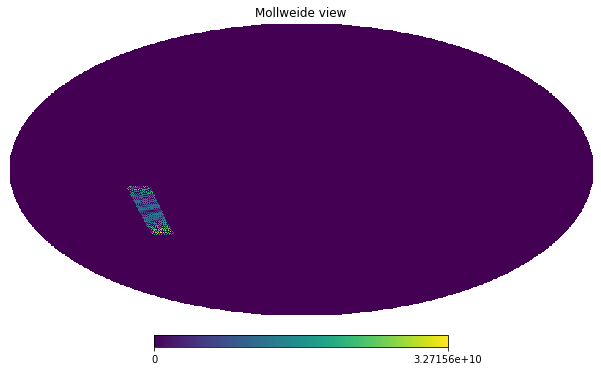

In [3]:
npp = hp.read_map('./out_maps/0/E_Q_telescope_all_time_all_invnpp.fits', verbose=False, dtype=np.float64)
hp.mollview(npp)

In [4]:
nside = 256
npix = hp.nside2npix(nside)
b = nmt.NmtBin.from_nside_linear(nside, 32)
ell = b.get_effective_ells()
mask = hp.read_map('./out_maps/0/E_Q_telescope_all_time_all_hits.fits', verbose=False, dtype=np.float64)
mask[np.where(mask>0)] = 1
mask_apo = nmt.mask_apodization(mask, 0.5, apotype='C1')

In [5]:
cl_in = []
cl_out = []
cl_pure = []


for i in range(nreal):
    f_in = nmt.NmtField(mask=np.ones(npix), maps=[E_Q_maps[i], E_U_maps[i]])
    f_out = nmt.NmtField(mask=mask, maps=[out_E_Q_maps[i], mask_apo*out_E_U_maps[i]])
    f_pure = nmt.NmtField(mask=mask, maps=[out_E_Q_maps[i], mask_apo*out_E_U_maps[i]], purify_b=True)


    cl_in.append(nmt.compute_full_master(f_in, f_in, b))
    cl_out.append(nmt.compute_full_master(f_out, f_out, b))
    cl_pure.append(nmt.compute_full_master(f_pure, f_pure, b))
    
def cl2dl(*cl_list):
    for cl in cl_list:
        cl *= ell*(ell+1) 

cl2dl(cl_in, cl_out, cl_pure)

Text(0, 0.5, '$D_\\ell$')

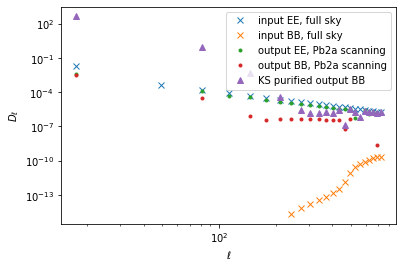

In [6]:
plt.loglog(ell, np.mean(cl_in, axis=0)[0], 'x',label='input EE, full sky')
plt.loglog(ell, np.mean(cl_in, axis=0)[3],'x', label='input BB, full sky')
plt.loglog(ell, np.mean(cl_out, axis=0)[0], '.', label='output EE, Pb2a scanning')
plt.loglog(ell, np.mean(cl_out, axis=0)[3], '.', label='output BB, Pb2a scanning')
plt.loglog(ell, np.mean(cl_pure, axis=0)[3], '^', label='KS purified output BB')

plt.legend()
plt.xlabel('$\ell$')
plt.ylabel('$D_\ell$')

Text(0, 0.5, '$\\sigma(D_\\ell)$')

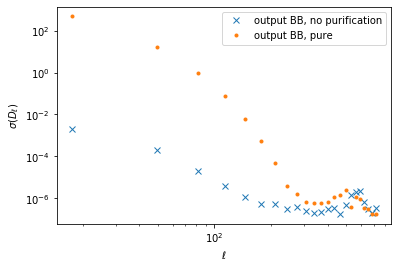

In [7]:
plt.loglog(ell, np.std(cl_out, axis=0)[3], 'x',label='output BB, no purification')
plt.loglog(ell, np.std(cl_pure, axis=0)[3], '.',label='output BB, pure')
plt.legend()
plt.xlabel('$\ell$')
plt.ylabel('$\sigma(D_\ell)$')